In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
import seaborn as sn
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import auc
from sklearn.metrics import roc_curve                # Calculate the ROC curve
from sklearn.metrics import precision_recall_curve   # Calculate the Precision-Recall curve
from sklearn.metrics import f1_score                 # Calculate the F-score


In [2]:
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point


def ROC(label, y_prob):
    fpr, tpr, thresholds = roc_curve(label, y_prob)
    roc_auc = auc(fpr, tpr)
    optimal_th, optimal_point = Find_Optimal_Cutoff(TPR=tpr, FPR=fpr, threshold=thresholds)
    return fpr, tpr, roc_auc, optimal_th, optimal_point
    

In [3]:
# Data Loading
f = r'C:\Users\User\VSCode\CDSS\output\CDSS_report_mdro_info.xlsx'

CDSS = pd.read_excel(f, dtype={'病歷號碼':'str'})
# m = CDSS[CDSS.openTime==CDSS.minTime]

In [4]:
# Filter Fault Time
CDSS['sendTime'] = pd.to_datetime(CDSS['sendTime'])
CDSS = CDSS[(CDSS['sendTime'] < pd.to_datetime('2022-03-07 00:00')) | (CDSS['sendTime'] > pd.to_datetime('2022-03-21 23:59'))]

CDSS = CDSS[['病歷號碼', 'bed', '就醫序號', '申請編號', 'strain', '部位', 'Age', '抗藥性菌株', 'examTime',
         'reportTime', 'openTime', '菌株', 'PredValue', 'sendTime', 'Group_Strain', 'PredLevel', 'Resist_bool']].drop_duplicates() 

# TH = 60
CDSS['TH60'] = np.where(CDSS['PredValue']>=60, True, False)


# TH = 85 (Recommend)
# CDSS['TH85'] = np.where(CDSS['PredValue']>=85, True, False)

In [5]:
# CDSS.to_excel(r'C:\Users\User\VSCode\CDSS_0420.xlsx')

In [5]:
CDSS.Group_Strain.value_counts()

Klebsiella pneumoniae      175
Enterococcus faecium       174
Escherichia coli           135
Staphylococcus aureus      120
Pseudomonas aeruginosa     109
Acinetobacter baumannii    105
Enterobacter cloacae        12
Morganella morganii          8
Name: Group_Strain, dtype: int64

In [6]:
# Strain 
SA = CDSS[CDSS.Group_Strain=='Staphylococcus aureus'].reset_index(drop=True)
EF = CDSS[CDSS.Group_Strain=='Enterococcus faecium'].reset_index(drop=True)
KP = CDSS[CDSS.Group_Strain=='Klebsiella pneumoniae'].reset_index(drop=True)
EC = CDSS[CDSS.Group_Strain=='Escherichia coli'].reset_index(drop=True)
PA = CDSS[CDSS.Group_Strain=='Pseudomonas aeruginosa'].reset_index(drop=True)
AB = CDSS[CDSS.Group_Strain=='Acinetobacter baumannii'].reset_index(drop=True)
MM = CDSS[CDSS.Group_Strain=='Morganella morganii'].reset_index(drop=True)
ECL = CDSS[CDSS.Group_Strain=='Enterobacter cloacae'].reset_index(drop=True)
# Resist
SA['Resist'] = np.where(SA['Resist_bool']==True, 'MRSA', 'MSSA')
KP['Resist'] = np.where(KP['Resist_bool']==True, 'CRKP', 'CSKP')
# SA['Resist_bool'] = np.where(SA['Resist']=='MRSA', 1, 0)
# SA.rename({'年齡':'Age', '預測值':'PredValue'}, axis=1, inplace=True)

# # scatter plot

# plt.figure(figsize=(16, 9))
# sn.set(font_scale = 1.5)
# plt.title('Staphylococcus aureus (Jan-Mar 2022)', fontsize = 25)
# # Acinetobacter baumannii   AB  CRAB    CSAB
# # Staphylococcus aureus     SA	MRSA	MSSA
# # Escherichia coli          EC	CREC	CSEC
# # Pseudomonas aeruginosa    PA	CRPA	CSPA
# # Klebsiella pneumoniae     KP	CRKP	CSKP
# # Morganella morganii       MM	CRMM	CSMM
# # Enterococcus faecium      EF	VRE	VSE

# ax = sn.scatterplot(data=SA, x="PredValue", y="Age", hue="Resist")
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# # plt.legend(loc='upper right')
# # sn.move_legend(ax, "lower right", bbox_to_anchor=(1, 1), frameon=True)

# plt.show()


# distribution
print('Strain: Staphylococcus aureus (Jan-Mar 2022)')
print('Amount:', SA['病歷號碼'].count())
print('Patient:', SA['病歷號碼'].drop_duplicates().count())
print()
print(SA.groupby('PredLevel')['Resist'].value_counts().sort_index())
SA.groupby('PredLevel')['PredValue'].describe()



Strain: Staphylococcus aureus (Jan-Mar 2022)
Amount: 120
Patient: 80

PredLevel  Resist
0~20%      MRSA       9
           MSSA      28
21~40%     MRSA       2
           MSSA       2
41~60%     MRSA       2
           MSSA       1
61~80%     MRSA       5
           MSSA       4
81~100%    MRSA      57
           MSSA      10
Name: Resist, dtype: int64


,count,mean,std,min,25%,50%,75%,max
PredLevel,,,,,,,,
0~20%,37.0,8.729730,4.758902,0.0,10.0,10.0,10.00,19.0
21~40%,4.0,26.750000,4.573474,22.0,23.5,26.5,29.75,32.0
41~60%,3.0,56.333333,4.725816,51.0,54.5,58.0,59.00,60.0
61~80%,9.0,73.000000,6.480741,64.0,67.0,75.0,79.00,80.0
81~100%,67.0,98.582090,2.758729,85.0,99.0,99.0,100.00,100.0


In [7]:
SA['TH85'] = np.where(SA['PredValue']>=85, True, False)

In [8]:
# SA.to_excel(r'C:\Users\User\VSCode\CDSS_SA.xlsx')

Threshold

<function matplotlib.pyplot.show(close=None, block=None)>

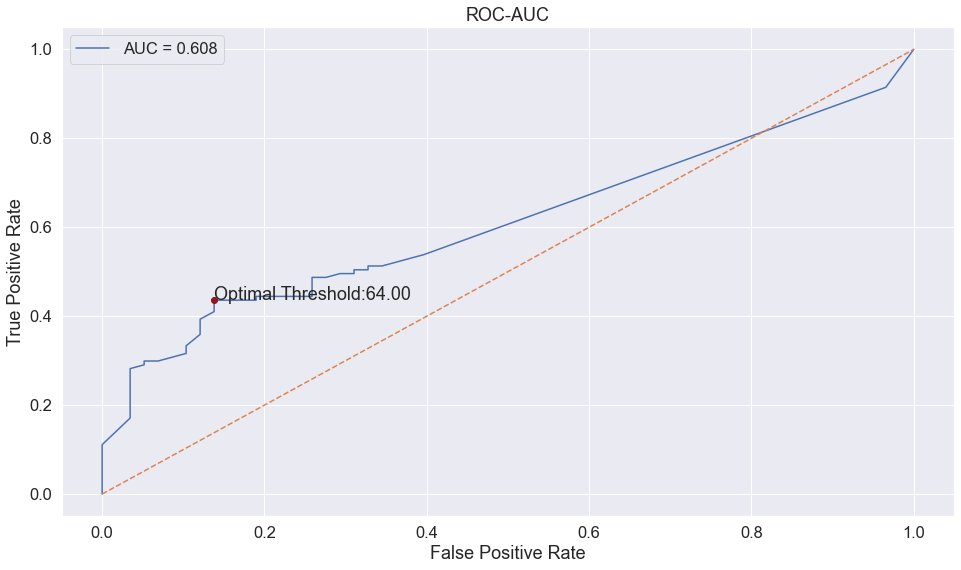

In [21]:
# Create the ROC curve
# fpr, tpr, thresholds = roc_curve(SA['Resist_bool'], SA.PredValue)

fpr, tpr, roc_auc, optimal_th, optimal_point = ROC(KP['Resist_bool'], KP.PredValue)

plt.figure(figsize=(16, 9))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.plot(optimal_point[0], optimal_point[1], marker="o", color="#981220")
plt.text(optimal_point[0], optimal_point[1], f'Optimal Threshold:{optimal_th:.2f}')
plt.title("ROC-AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show

In [23]:
roc_auc

0.6081638667845564

Best Threshold: 64 with G-Mean: 0.613
FPR: 0.1379, TPR: 0.4359


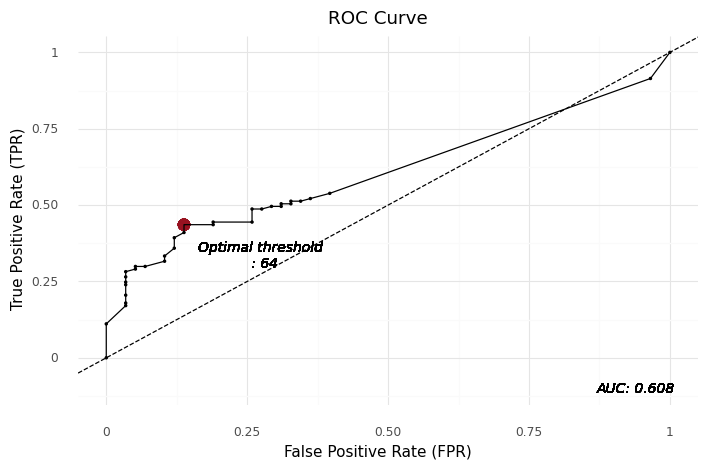

<ggplot: (185547911825)>

In [10]:
# Import module for data visualization
from plotnine import *
import plotnine

# Create the ROC curve
fpr, tpr, thresholds = roc_curve(KP['Resist_bool'], KP.PredValue)

# Plot the ROC curve
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})


# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.4)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_abline(color='black',
                linetype="dashed")+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n : {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    geom_text(aes(x = 0.8,
                  y = 0),
              label = 'AUC: {}'.format(round(roc_auc, ndigits = 3)),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

Confusion Matrix

Threshold  CRKP  CSKP
Actual               
CRKP         51    66
CSKP          8    50


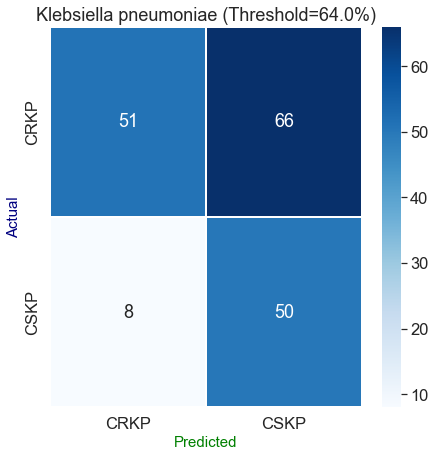

In [11]:
# confusion matrix
KP['Threshold'] = np.where(KP.PredValue >= optimal_th, 'CRKP', 'CSKP')
# SA['Predicted'] = np.where(SA['PredLevel'] != '81~100%', 'MSSA', 'MRSA')
confusion_matrix_SA = pd.crosstab(KP['Resist'], KP['Threshold'], rownames=['Actual'], colnames=['Threshold'])
print (confusion_matrix_SA)


plt.figure(figsize=(7,7))
sn.set(font_scale = 1.5)
sn.heatmap(confusion_matrix_SA, annot=True, fmt='d', linewidths=1.5, cmap='Blues')
plt.title(f'Klebsiella pneumoniae (Threshold={optimal_th:.1f}%)', fontsize = 18)
plt.xlabel('Predicted', fontsize = 15, color='green')
plt.ylabel('Actual', fontsize = 15, color='navy')
plt.show()

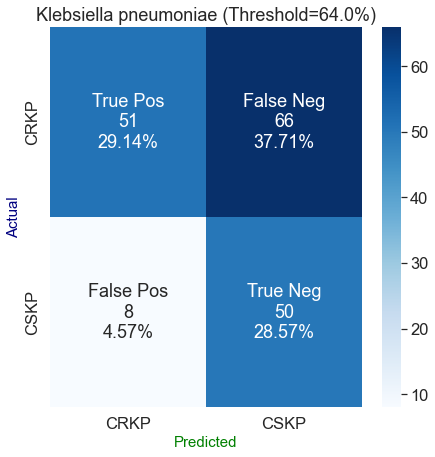

In [12]:
plt.figure(figsize=(7,7))
sn.set(font_scale = 1.5)
group_names = ['True Pos','False Neg','False Pos','True Neg'] 
# labels = np.asarray(labels).reshape(2,2)
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix_SA.to_numpy().flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix_SA.to_numpy().flatten()/np.sum(confusion_matrix_SA.to_numpy())]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sn.heatmap(confusion_matrix_SA, annot=labels, fmt='', cmap='Blues')
plt.title(f'Klebsiella pneumoniae (Threshold={optimal_th:.1f}%)', fontsize = 18)
plt.xlabel('Predicted', fontsize = 15, color='green')
plt.ylabel('Actual', fontsize = 15, color='navy')
plt.show()

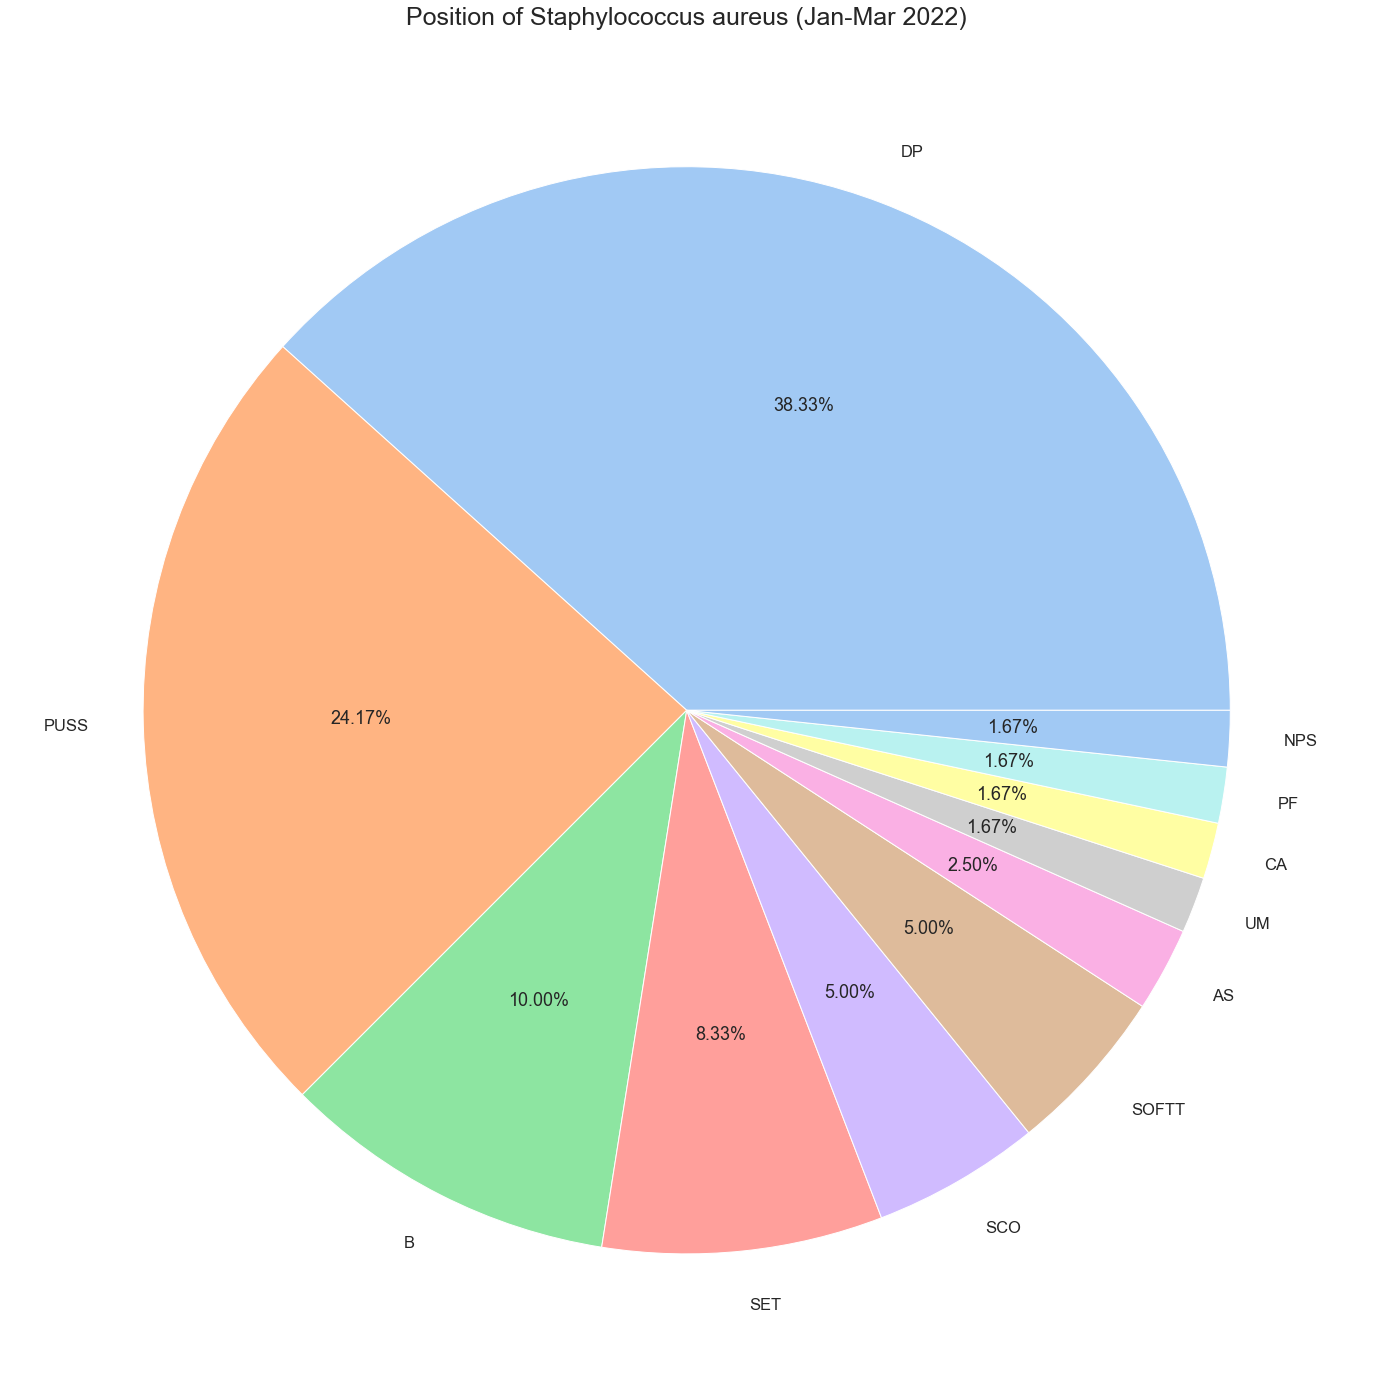

In [13]:
pieData = SA['部位'].value_counts()
label = pieData.index

colors = sn.color_palette('pastel')

#create pie chart
sn.set(font_scale = 1.5)
plt.figure(figsize=(25,25))
plt.pie(pieData, labels = label, autopct='%.2f%%', colors=colors)
plt.title('Position of Staphylococcus aureus (Jan-Mar 2022)', fontsize = 25)
plt.show()

In [14]:
# confusion matrix

for s in [SA, EF, KP, EC, PA, AB, MM, ECL]:
    for t in range(10, 100, 10):
        s['Threshold'] = np.where(s.PredValue >= t, True, False)
        # SA['Predicted'] = np.where(SA['PredLevel'] != '81~100%', 'MSSA', 'MRSA')
        confusion_matrix = pd.crosstab(s['Resist_bool'], s['Threshold'], rownames=['Actual'], colnames=['Threshold'])
        # print (confusion_matrix)
        
        # plt.figure(figsize=(7,7))
        # sn.set(font_scale = 1.5)
        # sn.heatmap(confusion_matrix_SA, annot=True, fmt='d', linewidths=1.5)
        # plt.title(f'{s.Group_Strain[0]} (Threshold={t:.1f}%)', fontsize = 18)
        # plt.xlabel('Predicted', fontsize = 15, color='green')
        # plt.ylabel('Actual', fontsize = 15, color='navy')
        
        # plt.savefig(r"C:\Users\User\VSCode\LULU\ConfusionMatric\\{}.png".format(s.Group_Strain[0] + str(t)))
        
        # plt.figure(figsize=(7,7))
        # sn.set(font_scale = 1.5)
        # group_names = ['True Pos','False Neg','False Pos','True Neg'] 
        # # labels = np.asarray(labels).reshape(2,2)
        # group_counts = ["{0:0.0f}".format(value) for value in
        #                 confusion_matrix_SA.to_numpy().flatten()]
        # group_percentages = ["{0:.2%}".format(value) for value in
        #                     confusion_matrix_SA.to_numpy().flatten()/np.sum(confusion_matrix_SA.to_numpy())]
        # labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
        #         zip(group_names,group_counts,group_percentages)]
        # labels = np.asarray(labels).reshape(2,2)
        # sn.heatmap(confusion_matrix_SA, annot=labels, fmt='', cmap='Blues')
        # plt.title(f'{s.Group_Strain[0]} (Threshold={t:.1f}%)', fontsize = 18)
        # plt.xlabel('Predicted', fontsize = 15, color='green')
        # plt.ylabel('Actual', fontsize = 15, color='navy')
        # plt.show()

In [15]:
# sensitive = {'Strain':[], 'Threshold':[], 'Value':[]}
Strain = []
Threshold = []
Sensitivity = []
Specificity = []
Positive_predictive_value = []
Negative_predictive_value = []

for s in [SA, EF, KP, EC, PA, AB, MM, ECL]:
    for t in range(0, 101):
        s['Threshold'] = np.where(s.PredValue >= t, True, False)
        # SA['Predicted'] = np.where(SA['PredLevel'] != '81~100%', 'MSSA', 'MRSA')
        
        Strain.append(s.Group_Strain[0])
        Threshold.append(t)
        Sensitivity.append(s[(s['Threshold']==True) & (s['Resist_bool']==True)]['Threshold'].count() / s[s['Resist_bool']==True]['Resist_bool'].count())
        Specificity.append(s[(s['Threshold']==False) & (s['Resist_bool']==False)]['Threshold'].count() / s[s['Resist_bool']==False]['Resist_bool'].count())
        Positive_predictive_value.append(s[(s['Threshold']==True) & (s['Resist_bool']==True)]['Threshold'].count() / s[s['Threshold']==True]['Resist_bool'].count())
        Negative_predictive_value.append(s[(s['Threshold']==False) & (s['Resist_bool']==False)]['Threshold'].count() / s[s['Threshold']==False]['Resist_bool'].count())
        
        # print (f"{s.Group_Strain[0]} (Threshold={t:.1f}%")
        # print(s[s['Threshold']==True & (s['Resist_bool']==True)]['Threshold'].count() / s[s['Resist_bool']==True]['Resist_bool'].count())

C:\Users\User\AppData\Local\Temp\ipykernel_9668\2662014543.py:19: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\User\AppData\Local\Temp\ipykernel_9668\2662014543.py:18: RuntimeWarning: invalid value encountered in longlong_scalars


In [17]:
df = pd.DataFrame((zip(Strain, Threshold, Sensitivity, Specificity, Positive_predictive_value, Negative_predictive_value)), 
                  columns = ['Strain', 'Threshold', 'Sensitivity', 'Specificity', 'Positive_predictive_value', 'Negative_predictive_value'])
# df.to_excel(r'C:\Users\User\VSCode\CDSS_Confusion_Matrix_0415.xlsx')

In [32]:
recommend = {'Strain':[], 'Threshold':[], 'Roc_Auc':[]}
for s in [SA, EF, KP, EC, PA, AB, MM, ECL]:
    fpr, tpr, roc_auc, optimal_th, optimal_point = ROC(s['Resist_bool'], s.PredValue)
    
    recommend['Strain'].append(s.Group_Strain[0])
    recommend['Threshold'].append(optimal_th)
    recommend['Roc_Auc'].append(round(roc_auc, 2))
    print(s.Group_Strain[0], ': ', optimal_th, ', Roc: ', round(roc_auc, 2))
    # print(optimal_th)

Staphylococcus aureus :  85 , Roc:  0.83
Enterococcus faecium :  100 , Roc:  0.64
Klebsiella pneumoniae :  64 , Roc:  0.61
Escherichia coli :  10 , Roc:  0.55
Pseudomonas aeruginosa :  14 , Roc:  0.47
Acinetobacter baumannii :  88 , Roc:  0.34
Morganella morganii :  11 , Roc:  0.5
Enterobacter cloacae :  11 , Roc:  0.44


In [27]:
pd.DataFrame(recommend)

,Strain,Threshold,Roc_Auc
0,Staphylococcus aureus,85,0.83
1,Enterococcus faecium,100,0.64
2,Klebsiella pneumoniae,64,0.61
3,Escherichia coli,10,0.55
4,Pseudomonas aeruginosa,14,0.47
5,Acinetobacter baumannii,88,0.34
6,Morganella morganii,11,0.50
7,Enterobacter cloacae,11,0.44


In [17]:
A = 0
for s in [SA, EF, KP, EC, PA, AB, MM, ECL]:
    A = A + s['病歷號碼'].drop_duplicates().count() 
print(A)

589


In [20]:
SA['Resist'] = np.where(SA['Resist_bool']==True, 1, 0)
SA['Non_Resist'] = np.where(SA['Resist_bool']==False, 1, 0)

condition_1 = [(SA['PredValue'] <= 10), (SA['PredValue'] > 10)&(SA['PredValue'] <= 20), 
             (SA['PredValue'] > 20)&(SA['PredValue'] <= 30), (SA['PredValue'] > 30)&(SA['PredValue'] <= 40),
             (SA['PredValue'] > 40)&(SA['PredValue'] <= 50), (SA['PredValue'] > 50)&(SA['PredValue'] <= 60), 
             (SA['PredValue'] > 60)&(SA['PredValue'] <= 70), (SA['PredValue'] > 70)&(SA['PredValue'] <= 80),
             (SA['PredValue'] > 80)&(SA['PredValue'] <= 90), (SA['PredValue'] > 90)&(SA['PredValue'] <= 100)]

value_1 = ['0~10%', '10~20%', '20~30%', '30~40%', '40~50%', '50~60%', '60~70%', '70~80%',
           '80~90%', '90~100%']
SA['PredLevel'] = np.select(condition_1, value_1) 

BBC_SA = SA.groupby('PredValue')[['Resist', 'Non_Resist']].sum()
# BBC_SA.index = ['0~5%', '5~10%', '10~15%', '15~20%', '20~25%', '25~30%', '30~35%', '35~40%',
#                 '40~45%', '45~50%', '50~55%', '55~60%', '60~65%', '65~70%', '70~75%', '75~80%',
#                 '80~85%', '85~90%', '90~95%', '95~100%']

KP['Resist'] = np.where(KP['Resist_bool']==True, 1, 0)
KP['Non_Resist'] = np.where(KP['Resist_bool']==False, 1, 0)
BBC_KP = KP.groupby('PredValue')[['Resist', 'Non_Resist']].sum()

In [21]:
BBC_SA = BBC_SA.sort_index(ascending=False)
BBC_KP = BBC_KP.sort_index(ascending=False)


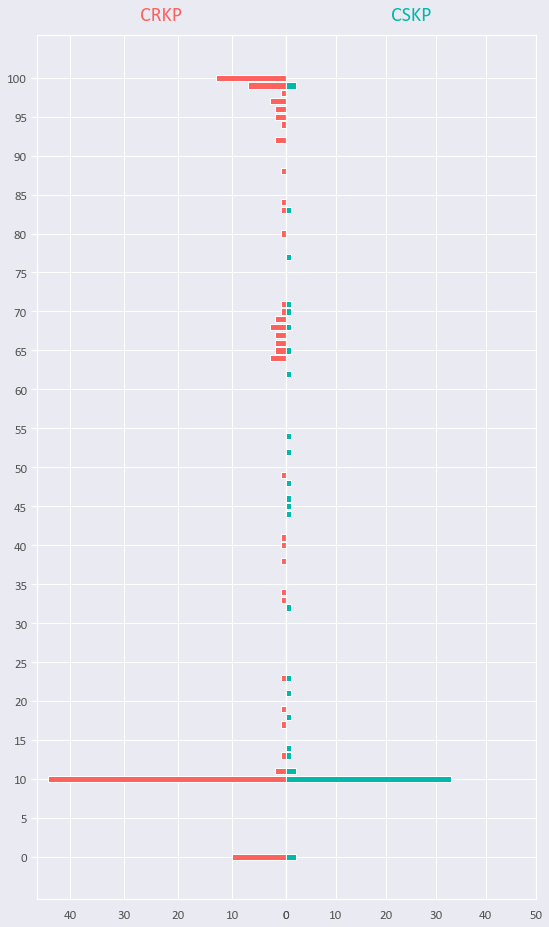

In [22]:
font_color = '#525252'
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'
index = BBC_KP.index
column0 = BBC_KP['Resist']
column1 = BBC_KP['Non_Resist']
title0 = 'CRKP'
title1 = 'CSKP'
fig, axes = plt.subplots(figsize=(9,16), facecolor=facecolor, ncols=2, sharey=True)
fig.tight_layout()

axes[0].barh(index, column0, align='center', color=color_red, zorder=10)
axes[0].set_title(title0, fontsize=20, pad=15, color=color_red, **hfont)
axes[1].barh(index, column1, align='center', color=color_blue, zorder=10)
axes[1].set_title(title1, fontsize=20, pad=15, color=color_blue, **hfont)
axes[0].invert_xaxis() 
plt.gca()

axes[0].set(yticks=range(0, 105, 5), yticklabels=range(0, 105, 5))
axes[0].yaxis.tick_left()
# axes[0].set_yticks(range(0, 101))
axes[0].tick_params(axis='y', colors='white') # tick color
axes[1].set_xticks([0, 10, 20, 30, 40, 50])

axes[1].set_xticklabels([0, 10, 20, 30, 40, 50])


for label in (axes[0].get_xticklabels() + axes[0].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)
for label in (axes[1].get_xticklabels() + axes[1].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)
    

# axes[0].axhline(y=85, color='blue', linestyle='--')
# axes[1].axhline(y=85, color='blue', linestyle='--')

# plt.annotate('Threshold=85%', xy=(25, 85), xytext=(25, 88), arrowprops = {'color':'blue'})

plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)


In [23]:
SA.columns

Index(['病歷號碼', 'bed', '就醫序號', '申請編號', 'strain', '部位', 'Age', '抗藥性菌株',
       'examTime', 'reportTime', 'openTime', '菌株', 'PredValue', 'sendTime',
       'Group_Strain', 'PredLevel', 'Resist_bool', 'TH60', 'Resist', 'TH85',
       'Threshold', 'Non_Resist'],
      dtype='object')

In [24]:
fig = make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_yaxes=True, horizontal_spacing=0)
# bar plot for tv shows
fig.append_trace(go.Bar(x=df_tv_show.rating, y=df_tv_show.tv_show, orientation='h', showlegend=True, 
                        text=df_tv_show.rating_final, name='TV Show', marker_color='#221f1f'), 1, 1)
# bar plot for movies
fig.append_trace(go.Bar(x=df_movie.rating, y=df_movie.movie, orientation='h', showlegend=True, text=df_movie.rating,
                        name='Movie', marker_color='#b20710'), 1, 2)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False, categoryorder='total ascending', ticksuffix=' ', showline=False)
fig.update_traces(hovertemplate=None, marker=dict(line=dict(width=0)))
fig.update_layout(title='Which has the highest rating TV shows or Movies?',
                  margin=dict(t=80, b=0, l=70, r=40),
                  hovermode="y unified", 
                  xaxis_title=' ', yaxis_title=" ",
                  plot_bgcolor='#333', paper_bgcolor='#333',
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  legend=dict(orientation="h", yanchor="bottom", y=1, xanchor="center", x=0.5),
                  hoverlabel=dict(bgcolor="black", font_size=13, font_family="Lato, sans-serif"))

NameError: name 'make_subplots' is not defined

In [25]:
position = CDSS.groupby(['Group_Strain', '部位', 'Resist_bool'])

In [26]:
PP = pd.DataFrame(position[['TH60']].value_counts(), columns=['Count'])

In [ ]:
# PP.to_excel(r'C:\Users\User\VSCode\CDSS_position.xlsx')

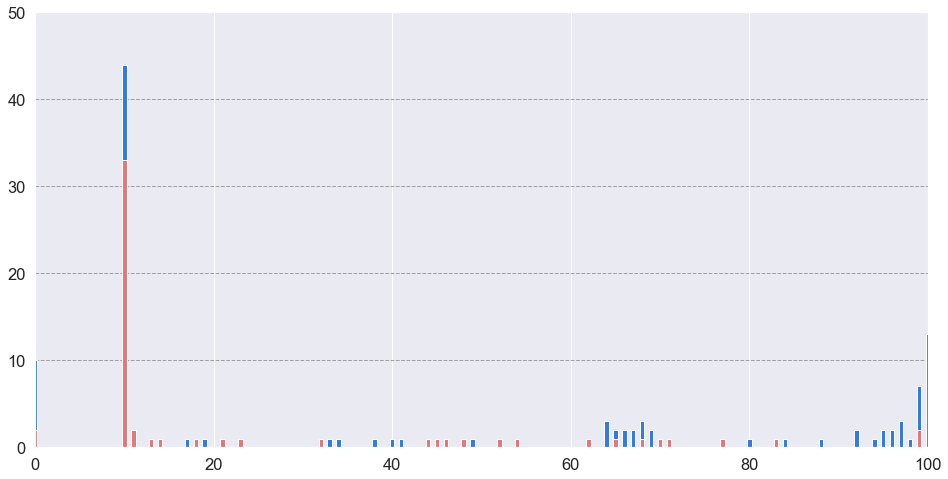

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 8))
plt.bar(index, column0, color = '#337AE3', width =0.5)
plt.bar(index, column1, color = '#E17979', width =0.5)

# x and y limits
plt.xlim(0, 100)
plt.ylim(0, 50)

ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.7)

In [29]:
PP

Count
Group_Strain            部位    Resist_bool TH60        
Acinetobacter baumannii AS    True        False     13
                                          True       3
                        B     False       False      2
                                          True       1
                              True        False      4
...                                                ...
Staphylococcus aureus   SOFTT False       False      2
                                          True       1
                              True        True       3
                        UM    False       False      1
                              True        True       1

[191 rows x 1 columns]

In [32]:
PPP = pd.DataFrame(position[['TH60']].count())

In [33]:
PPPP = pd.merge(PP, PPP, how='left' , on=index)

KeyError: Int64Index([100,  99,  98,  97,  96,  95,  94,  92,  88,  84,  83,  80,  77,
             71,  70,  69,  68,  67,  66,  65,  64,  62,  54,  52,  49,  48,
             46,  45,  44,  41,  40,  38,  34,  33,  32,  23,  21,  19,  18,
             17,  14,  13,  11,  10,   0],
           dtype='int64', name='PredValue')

In [38]:
PPP.index 

MultiIndex([('Acinetobacter baumannii',    'AS',  True),
            ('Acinetobacter baumannii',     'B', False),
            ('Acinetobacter baumannii',     'B',  True),
            ('Acinetobacter baumannii',    'BF',  True),
            ('Acinetobacter baumannii',    'BI', False),
            ('Acinetobacter baumannii',    'BI',  True),
            ('Acinetobacter baumannii',    'CA', False),
            ('Acinetobacter baumannii',    'CA',  True),
            ('Acinetobacter baumannii',    'DP',  True),
            ('Acinetobacter baumannii',    'PF',  True),
            ...
            (  'Staphylococcus aureus',  'PUSS', False),
            (  'Staphylococcus aureus',  'PUSS',  True),
            (  'Staphylococcus aureus',   'SCO', False),
            (  'Staphylococcus aureus',   'SCO',  True),
            (  'Staphylococcus aureus',   'SET', False),
            (  'Staphylococcus aureus',   'SET',  True),
            (  'Staphylococcus aureus', 'SOFTT', False),
            (  

In [37]:
PP.index

MultiIndex([('Acinetobacter baumannii',    'AS',  True, False),
            ('Acinetobacter baumannii',    'AS',  True,  True),
            ('Acinetobacter baumannii',     'B', False, False),
            ('Acinetobacter baumannii',     'B', False,  True),
            ('Acinetobacter baumannii',     'B',  True, False),
            ('Acinetobacter baumannii',    'BF',  True,  True),
            ('Acinetobacter baumannii',    'BF',  True, False),
            ('Acinetobacter baumannii',    'BI', False, False),
            ('Acinetobacter baumannii',    'BI',  True, False),
            ('Acinetobacter baumannii',    'CA', False, False),
            ...
            (  'Staphylococcus aureus',   'SCO',  True,  True),
            (  'Staphylococcus aureus',   'SCO',  True, False),
            (  'Staphylococcus aureus',   'SET', False, False),
            (  'Staphylococcus aureus',   'SET',  True,  True),
            (  'Staphylococcus aureus',   'SET',  True, False),
            (  'Staphylo